In [99]:
# Importing necessary libraries

import numpy as np
import os
import re
import sys
import glob
from textwrap import wrap
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Reshape, concatenate, Embedding, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [76]:
# Setting up the paths for images and captions dataset

img_path = '/home/devcontainers/Deep_Learning/RNN/image_caption/Flicker8k_Dataset'
caption_path = '/home/devcontainers/Deep_Learning/RNN/image_caption/Flickr8k.token.txt'
caption = pd.read_csv(caption_path, sep='\t', header=None, names=['image', 'caption'])

def clean_imagefile(filename):
    filename = filename.split('#')[0]
    match = re.match(r'(.*\.jpg)', filename)
    if match:
        return match.group(1)
    if not filename.endswith('.jpg'):
        filename += '.jpg'
    return filename
    
caption['image_clean'] = caption['image'].apply(clean_imagefile)
caption.head()

image  \
0  1000268201_693b08cb0e.jpg#0   
1  1000268201_693b08cb0e.jpg#1   
2  1000268201_693b08cb0e.jpg#2   
3  1000268201_693b08cb0e.jpg#3   
4  1000268201_693b08cb0e.jpg#4   

                                             caption  \
0  A child in a pink dress is climbing up a set o...   
1              A girl going into a wooden building .   
2   A little girl climbing into a wooden playhouse .   
3  A little girl climbing the stairs to her playh...   
4  A little girl in a pink dress going into a woo...   

                 image_clean  
0  1000268201_693b08cb0e.jpg  
1  1000268201_693b08cb0e.jpg  
2  1000268201_693b08cb0e.jpg  
3  1000268201_693b08cb0e.jpg  
4  1000268201_693b08cb0e.jpg

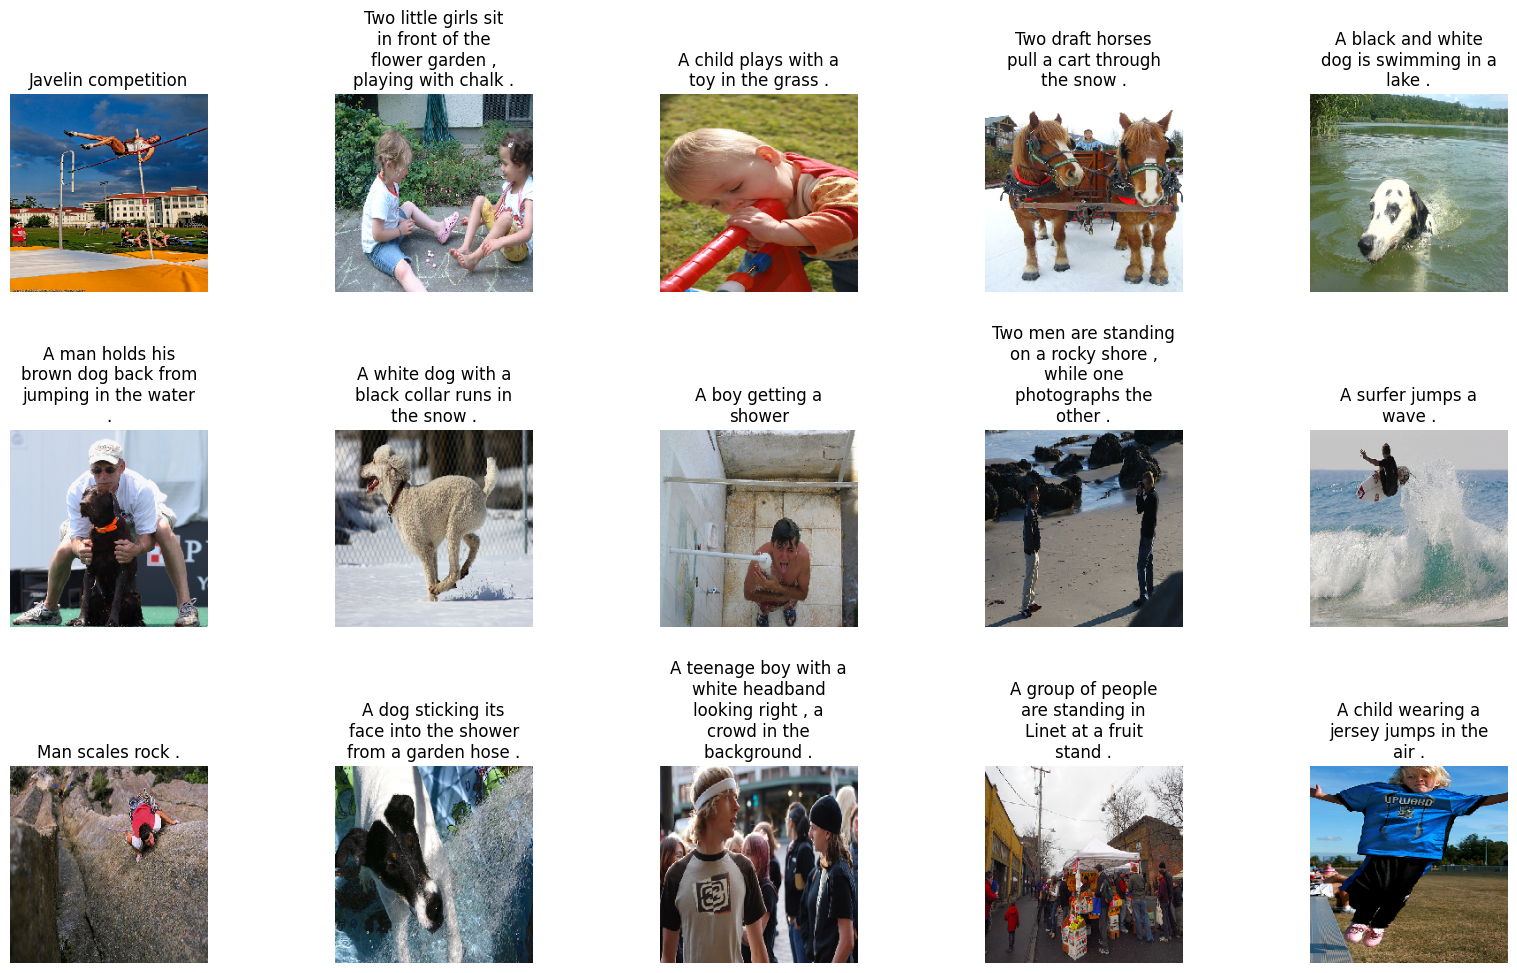

In [77]:
# Functions to read, preprocess and display images

def read_image(image_path):
    img = load_img(image_path, color_mode='rgb', target_size=(224, 224))
    img = img_to_array(img)
    # img = np.expand_dims(img, axis=0)
    # img = preprocess_input(img)
    img /= 255.0
    return img

def display_image(image_df):
    image_df = image_df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    i=0
    for i in range(len(image_df)):
        plt.subplot(5,5,i+1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        img = read_image(os.path.join(img_path, image_df.image_clean[i]))
        plt.imshow(img)
        plt.title("\n".join(wrap(image_df.caption[i], 20)))
        plt.axis('off')

display_image(caption.sample(15))

In [78]:
# Function to preprocess texts to reduce redundancy with start and end tokens
def preprocess_texts(caption_df):
    caption_df['caption'] = caption_df['caption'].apply(lambda x: x.lower())
    caption_df['caption'] = caption_df['caption'].apply(lambda x: re.sub("[^A-Za-z]"," ",x))
    caption_df['caption'] = caption_df['caption'].apply(lambda x: re.sub("\s+", " ",x))
    caption_df['caption'] = caption_df['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    caption_df['caption'] = caption_df['caption'].apply(lambda x: f"startseq {x} endseq")
    
    return caption_df

caption = preprocess_texts(caption)
captions = caption['caption'].tolist()
caption.head()

image  \
0  1000268201_693b08cb0e.jpg#0   
1  1000268201_693b08cb0e.jpg#1   
2  1000268201_693b08cb0e.jpg#2   
3  1000268201_693b08cb0e.jpg#3   
4  1000268201_693b08cb0e.jpg#4   

                                             caption  \
0  startseq child in pink dress is climbing up se...   
1    startseq girl going into wooden building endseq   
2  startseq little girl climbing into wooden play...   
3  startseq little girl climbing the stairs to he...   
4  startseq little girl in pink dress going into ...   

                 image_clean  
0  1000268201_693b08cb0e.jpg  
1  1000268201_693b08cb0e.jpg  
2  1000268201_693b08cb0e.jpg  
3  1000268201_693b08cb0e.jpg  
4  1000268201_693b08cb0e.jpg

In [96]:
# Tokenizing the captions to create list of indices
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = 1+len(tokenizer.word_index)
maxLen = max([len(c.split()) for c in captions])
print(f"Vocabulary Size: {vocab_size}, Max Length of Caption: {maxLen}")

images = caption['image_clean'].unique().tolist()
num_images = len(images)
print(f"Number of unique Images: {num_images}")

split_idx = round(num_images * 0.8)
train_images = images[:split_idx]
test_images = images[split_idx:]
print(f"Number of Training Images: {len(train_images)}, Number of Testing Images: {len(test_images)}")

train = caption[caption['image_clean'].isin(train_images)]
train.reset_index(inplace=True, drop=True)
test = caption[caption['image_clean'].isin(test_images)]
test.reset_index(inplace=True, drop=True)

Vocabulary Size: 8427, Max Length of Caption: 35
Number of unique Images: 8091
Number of Training Images: 6473, Number of Testing Images: 1618


In [80]:
# Getting the features or encodings for a given image using DenseNet201

img_model = DenseNet201()
model = Model(inputs=img_model.input, outputs=img_model.layers[-2].output)
features = {}
for image in caption['image_clean'].unique().tolist():
    img_file = os.path.join(img_path, image)
    if not os.path.exists(img_file):
        print(f"Missing: {img_file}")
        continue
    img = load_img(img_file, target_size=(224, 224))
    img = img_to_array(img)
    img /= 255.0
    img = np.expand_dims(img, axis=0)
    feature = model.predict(img)
    features[image] = feature

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, caption_df, X_col, y_col, batch_size, directory, tokenizer, vocab_size, maxLen, features, shuffle=True):
        self.caption_df = caption_df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.directory = directory
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.maxLen = maxLen
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.caption_df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.caption_df = self.caption_df.sample(frac=1).reset_index(drop=True)
            
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, index):
        batch_df = self.caption_df.iloc[index*self.batch_size:(index+1)*self.batch_size,:]
        X1, X2, y = self.__get_data(batch_df)
        return (X1, X2), y
    
    def __get_data(self, batch_df):
        X1, X2, y = [], [], []
        images = batch_df[self.X_col].tolist()
        for image in images:
            feature = self.features[image][0]
            captions = batch_df[batch_df[self.X_col] == image][self.y_col].tolist()
            for c in captions:
                seq = self.tokenizer.texts_to_sequences([c])[0]
                for i in range(1, len(seq)):
                    in_seq = seq[:i]
                    out_seq = seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.maxLen)[0]
                    out_seq = to_categorical(out_seq, num_classes=self.vocab_size)
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        
        return X1, X2, y

In [85]:
# Mapping the words to glove vector representations

embeddings_idx = {}
with open('/home/devcontainers/Flask/img_captioning/embeddings/glove.6B.300d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_idx[word] = coefs
        
print(f"Found {len(embeddings_idx)} word vectors.")

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxLen, trainable=False)

Found 400000 word vectors.


/home/devcontainers/miniconda3/envs/agents-env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(maxLen,))
fe1 = Dense(300, activation='relu')(input1)
fe1_reshaped = Reshape((1, 300), input_shape=(300,))(fe1)
se1 = embedding_layer(input2)
merged = concatenate([fe1_reshaped, se1], axis=1)
se2 = LSTM(300)(merged)
x = Dropout(0.5)(se2)
x = add([x, fe1])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=outputs)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

/home/devcontainers/miniconda3/envs/agents-env/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [88]:
caption_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 300)       │    576,300 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 300)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 300)   │  2,528,100 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 36, 300)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 300)       │    721,200 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 300)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 300)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     38,528 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8427)      │  1,087,083 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,951,211 (18.89 MB)

 Trainable params: 2,423,111 (9.24 MB)

 Non-trainable params: 2,528,100 (9.64 MB)

In [98]:
train_generator = DataGenerator(caption_df=train,X_col='image_clean',y_col='caption',batch_size=64,directory=img_path, tokenizer=tokenizer,vocab_size=vocab_size,maxLen=maxLen,features=features)
validation_generator = DataGenerator(caption_df=test,X_col='image_clean',y_col='caption',batch_size=64,directory=img_path, tokenizer=tokenizer,vocab_size=vocab_size,maxLen=maxLen,features=features)

model_checkpoint = ModelCheckpoint('caption_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

history = caption_model.fit(train_generator, validation_data=validation_generator, epochs=20, callbacks=[model_checkpoint, reduce_lr, early_stopping], verbose=1)

Epoch 1/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 5.6588
Epoch 1: val_loss improved from inf to 4.27550, saving model to caption_model.h5


505/505 ━━━━━━━━━━━━━━━━━━━━ 87s 162ms/step - loss: 5.6576 - val_loss: 4.2755 - learning_rate: 0.0010
Epoch 2/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 4.3329
Epoch 2: val_loss improved from 4.27550 to 3.96146, saving model to caption_model.h5


505/505 ━━━━━━━━━━━━━━━━━━━━ 92s 182ms/step - loss: 4.3327 - val_loss: 3.9615 - learning_rate: 0.0010
Epoch 3/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 4.0403
Epoch 3: val_loss improved from 3.96146 to 3.80892, saving model to caption_model.h5


505/505 ━━━━━━━━━━━━━━━━━━━━ 113s 223ms/step - loss: 4.0402 - val_loss: 3.8089 - learning_rate: 0.0010
Epoch 4/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 3.8454
Epoch 4: val_loss improved from 3.80892 to 3.72731, saving model to caption_model.h5


505/505 ━━━━━━━━━━━━━━━━━━━━ 125s 248ms/step - loss: 3.8454 - val_loss: 3.7273 - learning_rate: 0.0010
Epoch 5/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.7293
Epoch 5: val_loss improved from 3.72731 to 3.67139, saving model to caption_model.h5


505/505 ━━━━━━━━━━━━━━━━━━━━ 107s 212ms/step - loss: 3.7293 - val_loss: 3.6714 - learning_rate: 0.0010
Epoch 6/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 3.6179
Epoch 6: val_loss improved from 3.67139 to 3.63484, saving model to caption_model.h5


505/505 ━━━━━━━━━━━━━━━━━━━━ 108s 213ms/step - loss: 3.6179 - val_loss: 3.6348 - learning_rate: 0.0010
Epoch 7/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 3.5429
Epoch 7: val_loss improved from 3.63484 to 3.62624, saving model to caption_model.h5


505/505 ━━━━━━━━━━━━━━━━━━━━ 120s 237ms/step - loss: 3.5429 - val_loss: 3.6262 - learning_rate: 0.0010
Epoch 8/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 3.4644
Epoch 8: val_loss improved from 3.62624 to 3.61231, saving model to caption_model.h5


505/505 ━━━━━━━━━━━━━━━━━━━━ 117s 231ms/step - loss: 3.4644 - val_loss: 3.6123 - learning_rate: 0.0010
Epoch 9/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.4243
Epoch 9: val_loss improved from 3.61231 to 3.61186, saving model to caption_model.h5


505/505 ━━━━━━━━━━━━━━━━━━━━ 92s 183ms/step - loss: 3.4243 - val_loss: 3.6119 - learning_rate: 0.0010
Epoch 10/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 3.3603
Epoch 10: val_loss did not improve from 3.61186
505/505 ━━━━━━━━━━━━━━━━━━━━ 81s 160ms/step - loss: 3.3604 - val_loss: 3.6234 - learning_rate: 0.0010
Epoch 11/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 3.3277
Epoch 11: val_loss did not improve from 3.61186
505/505 ━━━━━━━━━━━━━━━━━━━━ 81s 160ms/step - loss: 3.3278 - val_loss: 3.6235 - learning_rate: 0.0010
Epoch 12/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 3.2855
Epoch 12: val_loss did not improve from 3.61186
505/505 ━━━━━━━━━━━━━━━━━━━━ 85s 168ms/step - loss: 3.2855 - val_loss: 3.6287 - learning_rate: 0.0010
Epoch 13/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 3.2021
Epoch 13: val_loss did not improve from 3.61186
505/505 ━━━━━━━━━━━━━━━━━━━━ 85s 167ms/step - loss: 3.2021 - val_loss: 3.6363 - learning_rate: 2.0000e-04
Epoch 14/20
50

In [101]:
# plt.figure(figsize=(20,8))
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━

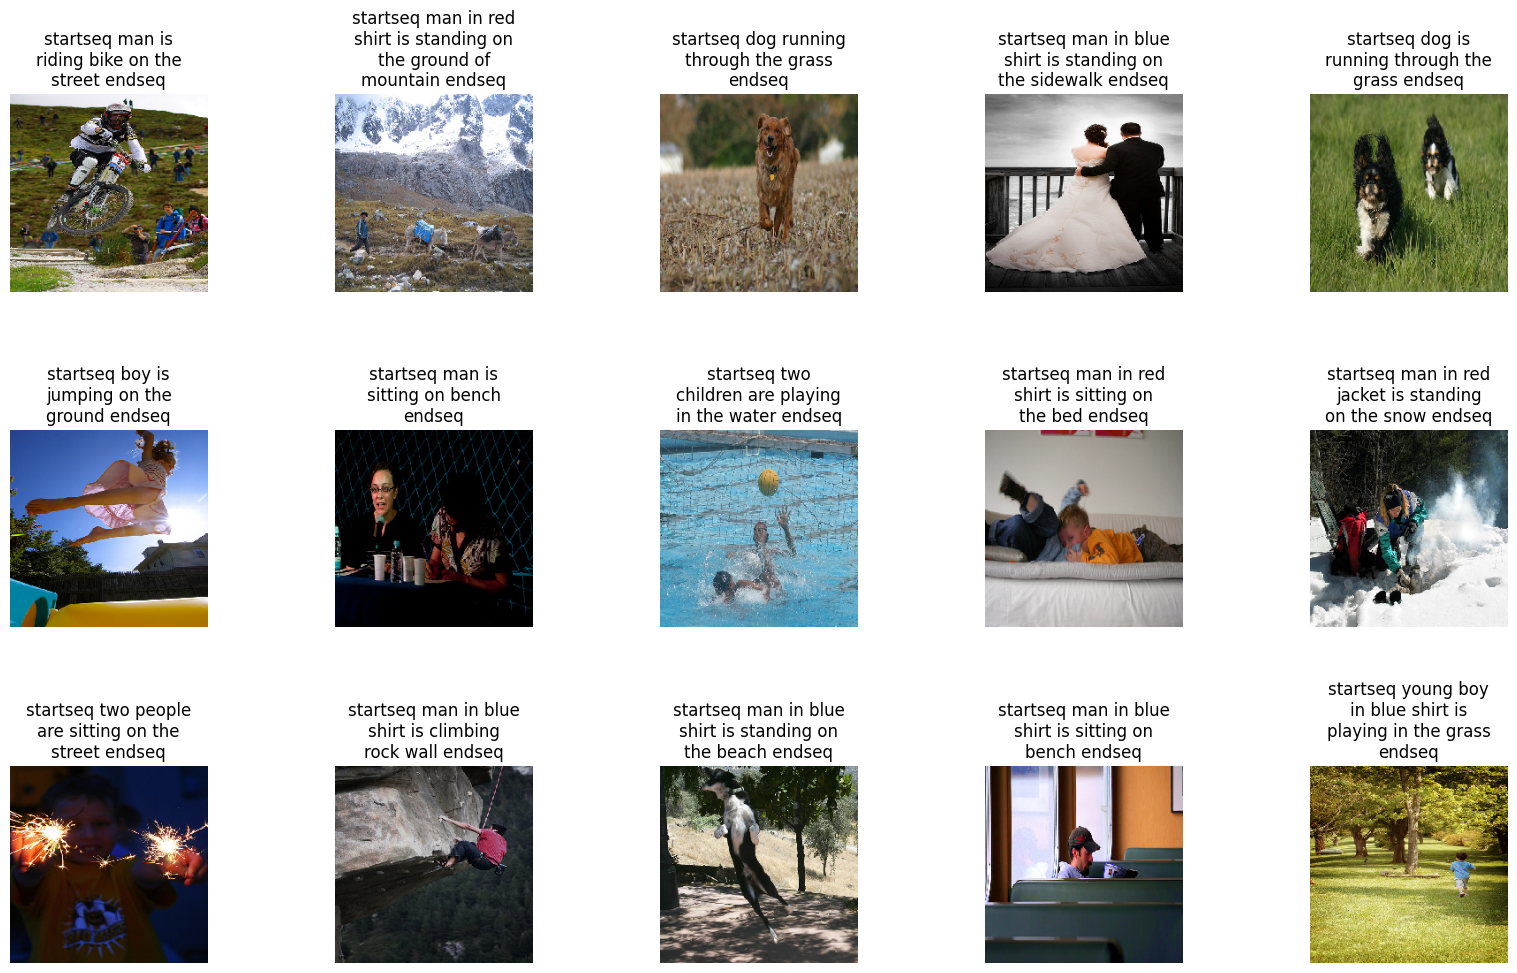

In [ ]:
def idx_to_word(idx,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==idx:
            return word
    return None

def predict_caption(model, image, tokenizer, maxLen, features):
    feature = features[image]
    in_text = "startseq"
    for i in range(maxLen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxLen)
        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
            
    return in_text 

samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

for idx,value in samples.iterrows():
    img = load_img(os.path.join(img_path, value['image_clean']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    caption = predict_caption(caption_model, value['image_clean'], tokenizer, maxLen, features)
    samples.loc[idx,'caption'] = caption
    
display_image(samples)